In [21]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
import math
from scipy.interpolate import interp1d

In [22]:
def neu_diff_flux(energy):  # GeVs
    return 1.8 * (10 ** -18) * (((energy) / (10 ** 5)) ** (-2.52))  # Single power law formula for diffuse neutrino flux
    #/cm^2/s/sr/GeV

In [23]:
#these are values I got from Web Plot Digitizing a CC cross section plot
xs_energies =  [9.98080495607805,
20.998018053876827,
71.59732457299745,
195.63029063568808,
666.9767142701296,
2617.6906006049767,
11125.842153739322,
109783.1765184451,
2562687.509604299,
36940357.82428877,
663344496.668366,
3504806387.090148,
41295060959.3206,
422796003979.0706,
124436989287.35977,
10350845957.459944,
1450095398.5416524,
153442766.75056547,
9634704.158738362,
456524.62382801063]
xs_values = [5.857020818056673e-11, 1.1497569953977356e-10, 3.853528593710535e-10,
             9.770099572992246e-10, 3.1992671377973846e-9, 1.2045035402587812e-8, 4.132012400115343e-8,
             1.9179102616724926e-7, 9.111627561154906e-7, 0.0000030538555088334187, 0.000009111627561154906,
             0.000017073526474706923, 0.00004132012400115343, 0.00009326033468832218,
             0.0000628029144183426,
             0.000025353644939701165,
             0.000012045035402587836,
             0.000005336699231206323,
             0.0000017475284000076865,
             4.3287612810830616e-7]
cc_cross_section = interp1d(xs_energies, xs_values,kind='linear')  #mb


In [24]:
def total_diff_neutrino_flux_moon(energy):
    moon_solid_angle = 6.4 * 10 ** -5
    ice_cube_area = 10 ** 10 # cm^2
    return neu_diff_flux(energy) * moon_solid_angle * ice_cube_area 
    #/cm^2/s


In [25]:
def diff_muon_flux_per_cubic_cm_moon(energy):
    density = 3.34 # g / cm^3
    nucleon_mass = 1.66 * 10 ** -24
    nucleon_density = density / nucleon_mass #nucleons per cm^3
    
    xs = cc_cross_section(energy) * (10 ** -27)#converts mb to cm^2
    
    r_moon  = 1.74 * 10 ** 8 # in cm
    area_moon = math.pi * r_moon ** 3
    
    flux = total_diff_neutrino_flux_moon(energy) / area_moon 
    
    return nucleon_density * xs * flux # R = nt sigma flux
    #interactions /cm^3/s    

In [26]:
def find_muon_final_energy(E0, distance_through_moon): #energy in GeV, distance in cm
  #constants
  zeta = 2.4 * 10**5 # g / cm^2
  epsilon = 500 #GeV
  moon_density = 3.34 # g / cm^3
  column_depth = distance_through_moon * moon_density

  E_final = ((E0 + epsilon) * np.exp(- column_depth / zeta)) - epsilon
  
  if E_final < 0.1:
    E_final = 0.1

  return E_final

In [27]:
def find_muon_initial_energy(E_final, distance_through_moon):
    zeta = 2.4 * 10**5 # g / cm^2
    epsilon = 500 #GeV
    moon_density = 3.34 # g / cm^3
    column_depth = distance_through_moon * moon_density
    
    E_initial = ((E_final + epsilon) * np.exp( column_depth / zeta)) - epsilon
    
    return E_initial


In [28]:
#this function finds the flux of signal muons /gev/cm^3/s given a certain moon depth and final energy
#it's different frim the other function in that it give it in terms of the initital energy
def find_muon_diff_flux_per_cm3_given_E_final(E_final, distance_through_moon):
    E_initial = find_muon_initial_energy(E_final, distance_through_moon)
    return diff_muon_flux_per_cubic_cm_moon(E_initial) #flux

In [29]:
def muon_survival_to_earth_probability(energy): #energy in GeVs
    dist_moon_to_earth = 3.8 * 10 ** 8 #m
    c = 3 * 10 ** 8 # m/s
    mass_muon = 105.7 * 10 ** -3 #GeV
    coordinate_time = dist_moon_to_earth / c # s
    lifetime = 2.2 * 10 ** -6 # s
    
    proper_time = (mass_muon / energy) * coordinate_time # s
    survival_probability = np.exp(- proper_time / lifetime)
    
    return survival_probability

In [30]:
def find_total_diff_muon_flux(E_final):
    r_moon  = 1.74 * 10 ** 8 # in cm
    shell_area = 2 * math.pi * r_moon ** 2 #for now, treating each shell as the surface of a hemisphere
    L = 10 ** 5 # cm, characteristic distance to make integration easuer
    flux_per_shell = lambda distance: find_muon_diff_flux_per_cm3_given_E_final(E_final, L * distance) * shell_area  * muon_survival_to_earth_probability(E_final)
    total_flux = quad(flux_per_shell, 0, 10 ** 5.6 / L)[0] * L
    return total_flux

In [31]:
find_total_diff_muon_flux(10 ** 5)

9.340149290968914e-26

In [32]:
signal_muon_energies = np.logspace(3, 9, 1000)

def make_diff_muon_flux_array(energies):
    diff_flux_arr = []
    for energy in energies:
        diff_flux_arr.append(find_total_diff_muon_flux(energy))
    
    return diff_flux_arr

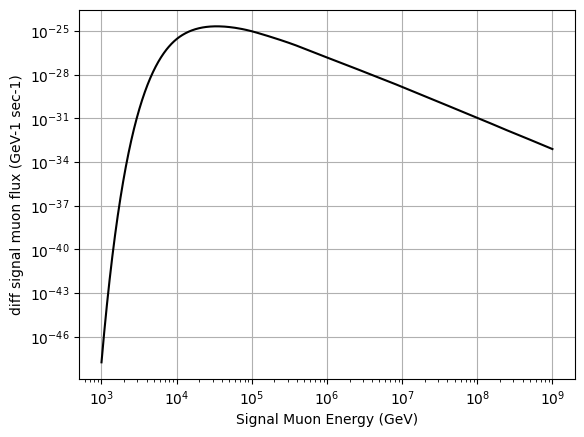

In [33]:
plt.plot(signal_muon_energies, make_diff_muon_flux_array(signal_muon_energies),'k')
plt.xlabel('Signal Muon Energy (GeV)')
plt.ylabel('diff signal muon flux (GeV-1 sec-1)')
plt.xscale('log')
plt.yscale('log')
plt.grid(True)    

In [34]:
interp_diff_muon_flux = interp1d(signal_muon_energies, make_diff_muon_flux_array(signal_muon_energies), kind='cubic')

In [35]:
def find_muon_flux_over_range(E0, E_final):
    characteristic_energy = 10 ** 5 # x = E / characteristic energy, so we can make integration easier
    integrand = lambda x: interp_diff_muon_flux(x * characteristic_energy) 
    return quad(integrand, E0 / characteristic_energy, E_final / characteristic_energy)[0] * characteristic_energy

In [36]:
find_muon_flux_over_range(10**3, 10**9)

4.06212563023815e-21